In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


import datetime
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
import sys
import os

In [2]:
def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]


def generate_label(obj):
    if obj.find('name').text == "with_mask": 
        return 2 
    elif obj.find('name').text == "mask_weared_incorrect": 
        return 3 
    return 1

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target
    
def get_filename(time: int, util_name:str =""):   
    filename = str(time.strftime('%b-%d-%Y_%H-%M-%S'))
    if util_name != "":
        filename = util_name+"_"+filename
    return filename

In [3]:
imgs = list(sorted(os.listdir("dataset/images")))
labels = list(sorted(os.listdir("dataset/annotations/")))

In [4]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir("dataset/images/")))
#         self.labels = list(sorted(os.listdir("/kaggle/input/face-mask-detection/annotations/")))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("dataset/images/", file_image)
        label_path = os.path.join("dataset/annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [5]:
def collate_fn(batch):
    return tuple(zip(*batch))

data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

dataset = MaskDataset(data_transform)
samples = []

for i in range(len(dataset)):
    samples.append(dataset[i])

    
# REMOVE/COMMENT THE BELOW STATEMENT
# samples = samples[:10]
    
train_size = int(0.9*len(samples))
samples_train = samples[:train_size]
samples_val = samples[train_size:]

train_data_loader = torch.utils.data.DataLoader(
 samples_train, batch_size=2, collate_fn=collate_fn)

val_data_loader = torch.utils.data.DataLoader(
 samples_val, batch_size=2, collate_fn=collate_fn)

In [6]:
print(len(train_data_loader))
print(len(val_data_loader))
torch.cuda.is_available()

384
43


False

In [7]:
for imgs, annotations in val_data_loader:
    for i in range(len(annotations)):
        if annotations[i]['image_id'] == 767:
            print(annotations[i])

{'boxes': tensor([[116.,  36., 144.,  71.]]), 'labels': tensor([2]), 'image_id': tensor([767])}


# Model

In [8]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)

    return model

model = get_model_instance_segmentation(3)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/madhuaithal/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


# Train Model

In [22]:
time = datetime.datetime.now()
saves_dir = os.path.join('saves', get_filename(time))
Path(saves_dir).mkdir(parents=True, exist_ok=True)

summ_filename = os.path.join(saves_dir,'tensorboard_summary')
writer = SummaryWriter(summ_filename)

num_epochs = 1
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_train_dataloader = len(train_data_loader)

best_val_loss = sys.maxsize
best_epoch = -1

for epoch in range(num_epochs):
    i = 0    
    epoch_loss = []
    val_epoch_loss = []
    print("Epoch:", epoch)
    
    model.train()
    
    train_iou_vals = []
    
    for imgs, annotations in train_data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        print("train:", loss_dict)
        
        # loss_dict consists of multiple losses such as classification loss, bounding box loss, and two other losses.
        losses = sum([loss for loss in loss_dict.values()])

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()         
#         print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')

        epoch_loss.append(losses.detach().cpu().numpy())
    
    with torch.no_grad():
        for imgs, annotations in val_data_loader:
            imgs = list(img.to(device) for img in imgs)
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
            loss_dict = model(imgs, annotations)
            losses = sum([loss for loss in loss_dict.values()])

            val_epoch_loss.append(losses.detach().cpu().numpy())
    
    torch.save(model.state_dict(),os.path.join(saves_dir, 'model_'+str(epoch)+'_epochs.pt'))
    avg_epoch_loss = np.mean(epoch_loss)
    avg_val_epoch_loss = np.mean(val_epoch_loss)
    writer.add_scalars("losses", {
        "avg_training_loss": avg_epoch_loss,
        "avg_val_loss": avg_val_epoch_loss
    }, epoch)
#     writer.add_scalar("avg_val_loss", avg_val_epoch_loss, epoch)
    
    print("Avg training loss:", avg_epoch_loss)
    print("Avg validation loss:", avg_val_epoch_loss)
    
    
    if avg_val_epoch_loss<best_val_loss:
        best_val_loss=avg_val_epoch_loss
        best_epoch = epoch
        
print("===================================")        
print("Best model details:")
print("Epoch:", best_epoch)
print("Min validation loss:", best_val_loss)

Epoch: 0
train: {'loss_classifier': tensor(1.6360, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.1055, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.2098, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0678, device='cuda:0', grad_fn=<DivBackward0>)}
train: {'loss_classifier': tensor(0.8385, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.1264, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1855, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0426, device='cuda:0', grad_fn=<DivBackward0>)}
train: {'loss_classifier': tensor(0.3217, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.1479, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0566, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0115, device='cuda:0', grad_

# Function to plot image

In [9]:
def plot_image_old(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()
    
def plot_image_new(img_tensor, annotation, block=True):
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data
    # Display the image
    ax.imshow( np.array( img.permute(1, 2, 0) ) )

    for box, label in zip( annotation["boxes"], annotation["labels"] ):
        xmin, ymin, xmax, ymax = box
        # Create a Rectangle patch
        if label==1:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='b',facecolor='none')
        else:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        ax.axis("off")
    plt.show(block=block)

(405, 442)
torch.Size([1, 3, 442, 405])
[{'boxes': tensor([[104.5182, 136.7035, 241.7958, 348.8611],
        [404.9615,   5.1595, 405.0000,  11.6938],
        [404.9615,   5.1712, 405.0000,  11.7033],
        [404.9614,   5.1412, 405.0000,  11.6711]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 2, 1, 3], device='cuda:0'), 'scores': tensor([0.9974, 0.1672, 0.1578, 0.1291], device='cuda:0',
       grad_fn=<IndexBackward>)}]
Predict sample image with loaded model


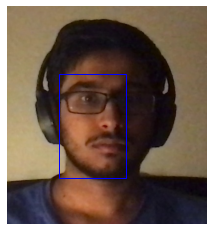

In [38]:
img_path = "sample_images/3.jpg"
img_sample_input = Image.open(img_path).convert("RGB")

if data_transform is not None:
    img_sample_input = data_transform(img_sample_input)
    
img_sample_input = torch.unsqueeze(img_sample_input, 0).to(device)
# print(img_sample_input.shape)

model2 = get_model_instance_segmentation(3)
model2.load_state_dict(torch.load('saves/Dec-01-2020_04-47-26/model_9_epochs.pt'))
model2.eval()
model2.to(device)


pred_sample_input = model2(img_sample_input)

print(pred_sample_input)
print("Predict sample image with loaded model")
plot_image_new(img_sample_input[0], pred_sample_input[0])

In [13]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    bb1 = [val.detach().cpu().numpy() for val in bb1]
    bb2 = [val.detach().cpu().numpy() for val in bb2]
#     print(bb1, bb2)
#     print(bb1[0], bb1[1])
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    x_right = min(bb1[2], bb2[2])
    y_top = max(bb1[1], bb2[1])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
#     print(iou)
#     if iou>=0.0 and iou<=1.0:
#         return iou, True
#     else:
#         return iou, False
    assert iou >= 0.0
    assert iou <= 1.0
    return iou
    


In [14]:
def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """
    all_pred_indices= range(len(pred_boxes))
    all_gt_indices=range(len(gt_boxes))
    if len(all_pred_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    if len(all_gt_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    
    gt_idx_thr=[]
    pred_idx_thr=[]
    ious=[]
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou= get_iou(gt_box, pred_box)
            
            if iou >iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)
    iou_sort = np.argsort(ious)[::1]
    if len(iou_sort)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    else:
        gt_match_idx=[]
        pred_match_idx=[]
        for idx in iou_sort:
            gt_idx=gt_idx_thr[idx]
            pr_idx= pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if(gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp= len(gt_match_idx)
        fp= len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)
    return {'true_positive': tp, 'false_positive': fp, 'false_negative': fn}

In [15]:
# def  get_avg_precision_at_iou(gt_boxes, pred_bb, iou_thr=0.5):
    
#     model_scores = get_model_scores(pred_bb)
#     sorted_model_scores= sorted(model_scores.keys())
# # Sort the predicted boxes in descending order (lowest scoring boxes first):
#     for img_id in pred_bb.keys():
        
#         arg_sort = np.argsort(pred_bb[img_id]['scores'])
#         pred_bb[img_id]['scores'] = np.array(pred_bb[img_id]['scores'])[arg_sort].tolist()
#         pred_bb[img_id]['boxes'] = np.array(pred_bb[img_id]['boxes'])[arg_sort].tolist()
#     pred_boxes_pruned = deepcopy(pred_bb)
    
#     precisions = []
#     recalls = []
#     model_thrs = []
#     img_results = {}
#     # Loop over model score thresholds and calculate precision, recall
#     for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
#             # On first iteration, define img_results for the first time:
#         print("Mode score : ", model_score_thr)
#         img_ids = gt_boxes.keys() if ithr == 0 else model_scores[model_score_thr]
#         for img_id in img_ids:
               
#             gt_boxes_img = gt_boxes[img_id]
#             box_scores = pred_boxes_pruned[img_id]['scores']
#             start_idx = 0
#             for score in box_scores:
#                 if score <= model_score_thr:
#                     pred_boxes_pruned[img_id]
#                     start_idx += 1
#                 else:
#                     break 
#             # Remove boxes, scores of lower than threshold scores:
#             pred_boxes_pruned[img_id]['scores']= pred_boxes_pruned[img_id]['scores'][start_idx:]
#             pred_boxes_pruned[img_id]['boxes']= pred_boxes_pruned[img_id]['boxes'][start_idx:]
# # Recalculate image results for this image
#             print(img_id)
#             img_results[img_id] = get_single_image_results(gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr=0.5)
# # calculate precision and recall
#         prec, rec = calc_precision_recall(img_results)
#         precisions.append(prec)
#         recalls.append(rec)
#         model_thrs.append(model_score_thr)
#     precisions = np.array(precisions)
#     recalls = np.array(recalls)
#     prec_at_rec = []
#     for recall_level in np.linspace(0.0, 1.0, 11):
#         try:
#             args= np.argwhere(recalls>recall_level).flatten()
#             prec= max(precisions[args])
#             print(recalls,"Recall")
#             print(      recall_level,"Recall Level")
#             print(       args, "Args")
#             print(       prec, "precision")
#         except ValueError:
#             prec=0.0
#         prec_at_rec.append(prec)
#     avg_prec = np.mean(prec_at_rec) 
#     return {
#         'avg_prec': avg_prec,
#         'precisions': precisions,
#         'recalls': recalls,
#         'model_thrs': model_thrs}

In [17]:
model4 = get_model_instance_segmentation(3)
model4.load_state_dict(torch.load('saves/final_run/model_2_epochs.pt', map_location=device))
model4.eval()
model4.to(device)

iou_vals = []

# TP, FP, TN, FN = 0, 0, 0, 0
accuracy_nos = {
    'true_positive':0,
    'false_positive':0,
    'false_negative':0
}

with torch.no_grad():
    for imgs, annotations in val_data_loader:

        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        pred = model4(imgs)
        
        for i in range(len(annotations)):
            temp_dict = get_single_image_results(annotations[i]['boxes'], pred[i]['boxes'], 0.5)
            
            for k,v in temp_dict.items():
                accuracy_nos[k] += v
                
# #             plot_image_new(imgs[i], pred[i])
# #             print("prediction:", pred[i]['boxes'])
#             print("ground truth:", annotations[i])
            
# #             if len(pred[i]['labels']) == 0:
# #                 FN += len(pred[i]['labels'])

#             for m,ground_truth_box in enumerate(annotations[i]['boxes']):
#                 match_count = 0
#                 mismatch_count = 0
#                 for idx,label in enumerate(pred[i]['labels']):
#                     val = get_iou(pred[i]['boxes'][idx], ground_truth_box)                        
#                     if label == annotations[i]['labels'][m] and val>0.5:
#                         print('ground truth:', ground_truth_box)
#                         print('predicted box BB:', pred[i]['boxes'][idx])
#                         print('label, IOU:', label, val)
#                         match_count += 1
#                     else:
#                         mismatch_count+=1
                        
#                 if match_count>0:
#                     TP += 1
                    
# #             TP += match_count

#             if match_count > len(annotations[i]['boxes']):
#                 FP += match_count-len(annotations[i]['boxes'])
#             elif match_count < len(annotations[i]['boxes']):
#                 FN += len(annotations[i]['boxes'])-match_count


print(accuracy_nos)
print('Precision:', accuracy_nos['true_positive']/(accuracy_nos['true_positive']+accuracy_nos['false_positive']))

# print('TP:', TP)
# print('TN:', TN)
# print('FP:', FP)
# print('FN:', FN)
# print('Precision:', 1.0*TP/(TP+FP))
# print('Avg IOU score: ', np.mean(iou_vals))

{'true_positive': 360, 'false_positive': 836, 'false_negative': 11}
Precision: 0.3010033444816054


In [20]:
len(val_data_loader)

43

In [ ]:
# print([val.detach().cpu().numpy() for val in iou_vals])